In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models

In [ ]:
!pip3 install pixellib

In [ ]:
!pip install pillow==9.5.0
# install and restart

In [ ]:
from huggingface_hub import login
from google.colab import userdata
token = userdata.get('Nyi_token')
login(token=token)

In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import pipeline
import diffusers

In [ ]:
#depth_pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
depth_pipe = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-large-hf")

Device set to use cpu


In [ ]:
#img_path = "mmpose/datasets/human-tests/human (6).jpg"
img_path = "mmpose/datasets/vitpose_models/sheep.jpg"
image = Image.open(img_path).convert("RGB")
depth_out = depth_pipe(img_path)
depth_map = np.array(depth_out["depth"], dtype=np.float32)
depth_map = depth_map / np.max(depth_map)  # Normalize to 0-1

# Resize to match original image size
h, w = image.height, image.width
depth_map = cv2.resize(depth_map, (w, h), interpolation=cv2.INTER_LINEAR)
print(depth_map)

[[0.03921569 0.03921569 0.03921569 ... 0.03921569 0.03921569 0.03529412]
 [0.03921569 0.03921569 0.03921569 ... 0.03921569 0.03921569 0.03921569]
 [0.03921569 0.03921569 0.03921569 ... 0.03921569 0.03921569 0.03921569]
 ...
 [0.93333334 0.92941177 0.9254902  ... 0.9764706  0.9764706  0.9843137 ]
 [0.9098039  0.9254902  0.93333334 ... 0.9843137  0.98039216 0.9647059 ]
 [0.8        0.90588236 0.94509804 ... 0.99215686 0.96862745 0.8901961 ]]


In [ ]:
def depth_to_heatmap(depth_map_norm, colormap=cv2.COLORMAP_JET):
    """
    Convert a normalized depth map (0-1 float) to a colorful heatmap image (BGR uint8).

    Args:
        depth_map_norm (np.ndarray): Normalized depth map with values in [0, 1].
        colormap (int): OpenCV colormap type. Default is COLORMAP_JET.

    Returns:
        heatmap_bgr (np.ndarray): Color heatmap image in BGR uint8 format.
    """
    # Clip and scale depth to 0-255 uint8
    depth_uint8 = np.clip(depth_map_norm * 255, 0, 255).astype(np.uint8)

    # Apply colormap (e.g., JET)
    heatmap = cv2.applyColorMap(depth_uint8, colormap)

    return heatmap

In [ ]:
def depth_to_normals(depth_map: np.ndarray):
    """
    Convert a depth map to surface normals.
    depth_map: 2D numpy array, dtype float32, normalized or raw depth values.

    Returns:
        normals: (H, W, 3) float32 unit vectors in range [-1, 1]
        normal_rgb: (H, W, 3) uint8 visualization in range [0, 255]
    """
    # Smooth a bit to reduce noise
    depth_map = cv2.GaussianBlur(depth_map, (5, 5), 0)

    # Compute depth gradients
    dzdx = cv2.Sobel(depth_map, cv2.CV_32F, 1, 0, ksize=3)
    dzdy = cv2.Sobel(depth_map, cv2.CV_32F, 0, 1, ksize=3)

    # Build normal vectors: [-dzdx, -dzdy, 1]
    normals = np.dstack((-dzdx, -dzdy, np.ones_like(depth_map)))

    # Normalize to unit length
    norm = np.linalg.norm(normals, axis=2, keepdims=True)
    normals /= (norm + 1e-8)

    # Convert to RGB for visualization ([-1,1] → [0,255])
    normal_rgb = ((normals + 1) / 2 * 255).astype(np.uint8)

    return normals.astype(np.float32), normal_rgb

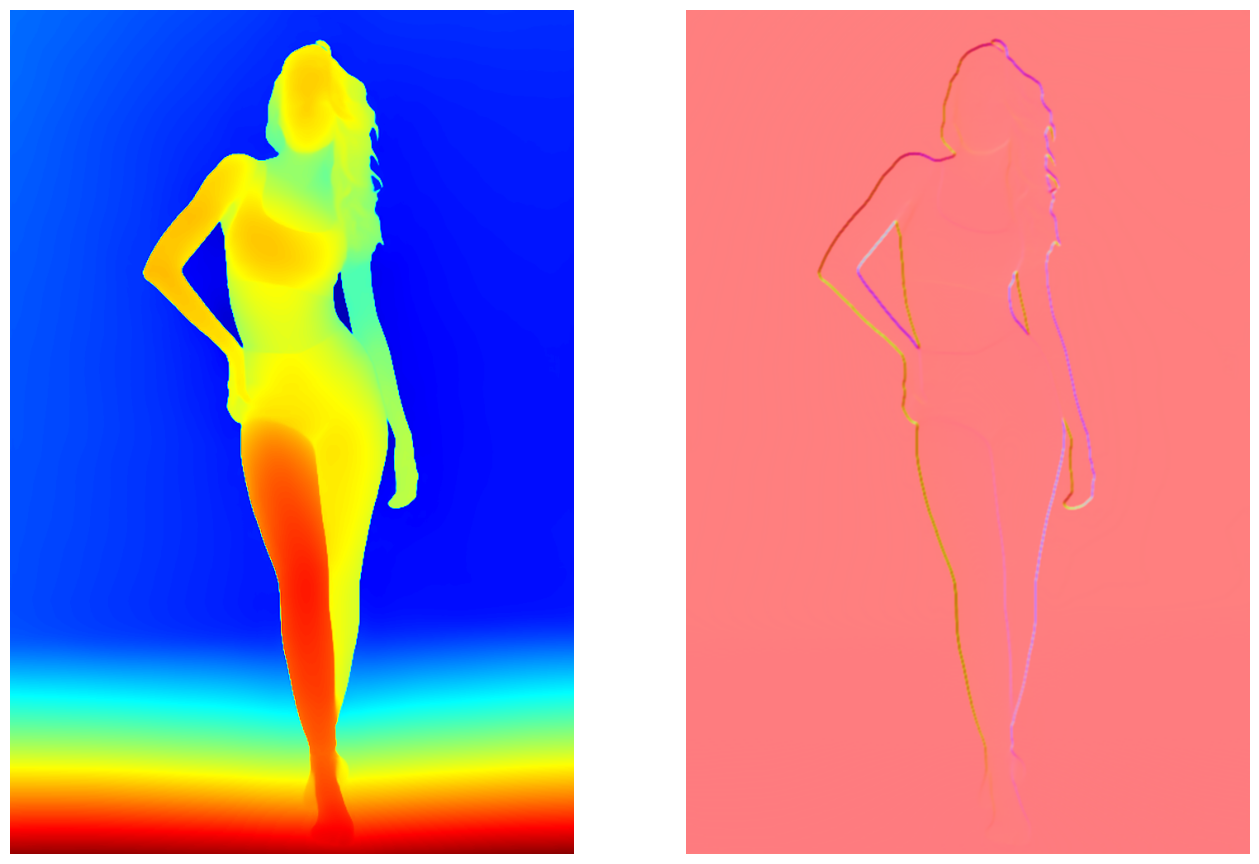

In [ ]:
output_img = image.copy()
output_img = cv2.cvtColor(np.array(output_img), cv2.COLOR_RGB2BGR)

img_depth = depth_to_heatmap(depth_map, colormap=cv2.COLORMAP_JET)
normals, normal_rgb = depth_to_normals(depth_map)

# Convert to RGB for matplotlib
img_depth = cv2.cvtColor(img_depth, cv2.COLOR_BGR2RGB)
output_img = cv2.cvtColor(normal_rgb, cv2.COLOR_BGR2RGB)

# Plot side-by-side
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(img_depth)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(output_img)

plt.show()

In [ ]:
import diffusers
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

pipe = diffusers.MarigoldNormalsPipeline.from_pretrained(
    "prs-eth/marigold-normals-v1-1", variant="fp16", torch_dtype=torch.float16
).to("cuda")

image = diffusers.utils.load_image("mmpose/datasets/vitpose_models/sheep.jpg")

normals = pipe(image)
depth = pipe(image, num_inference_steps=10, ensemble_size=5)

vis = pipe.image_processor.visualize_normals(normals.prediction)
vis2 = pipe.image_processor.visualize_normals(depth.prediction)
#vis[0].save("einstein_normals.png")
# Convert PIL Image to NumPy array before color conversion
output_img = cv2.cvtColor(np.array(vis[0]), cv2.COLOR_BGR2RGB)
output_img2 = cv2.cvtColor(np.array(vis2[0]), cv2.COLOR_BGR2RGB)

# Plot side-by-side
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(output_img)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(output_img2)

plt.show()

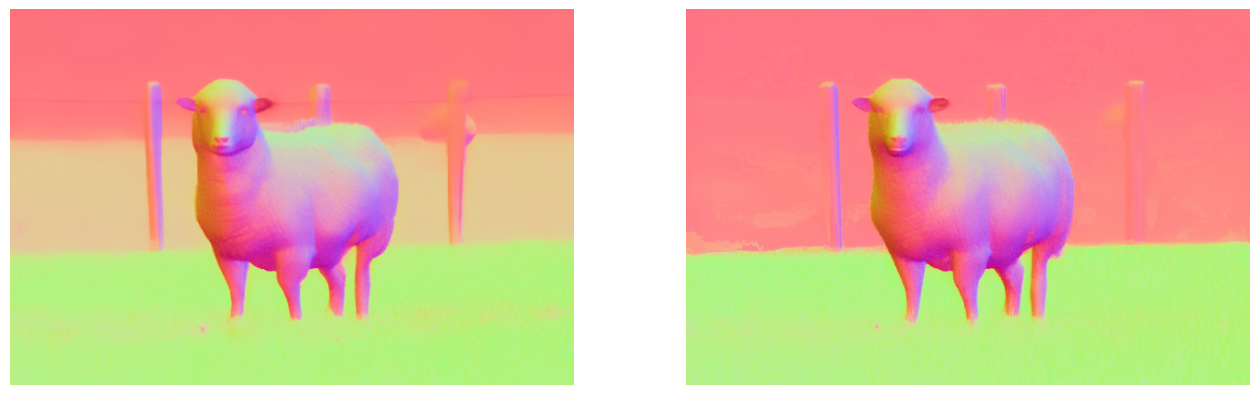

In [ ]:
def run_normals_inference(image):
    normals = pipe(image)
    depth = pipe(image, num_inference_steps=10, ensemble_size=5)

    vis = pipe.image_processor.visualize_normals(normals.prediction)
    vis2 = pipe.image_processor.visualize_normals(depth.prediction)
    #vis[0].save("einstein_normals.png")
    # Convert PIL Image to NumPy array before color conversion
    output_img = cv2.cvtColor(np.array(vis[0]), cv2.COLOR_BGR2RGB)
    output_img2 = cv2.cvtColor(np.array(vis2[0]), cv2.COLOR_BGR2RGB)

    # Plot side-by-side
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(output_img)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(output_img2)

    plt.show()
    return output_img, output_img2

pipe = diffusers.MarigoldNormalsPipeline.from_pretrained(
    "prs-eth/marigold-normals-v1-1", variant="fp16", torch_dtype=torch.float16
).to("cuda")

In [ ]:
image = diffusers.utils.load_image("mmpose/datasets/face-tests/girlface2.jpg")
run_normals_inference(image)

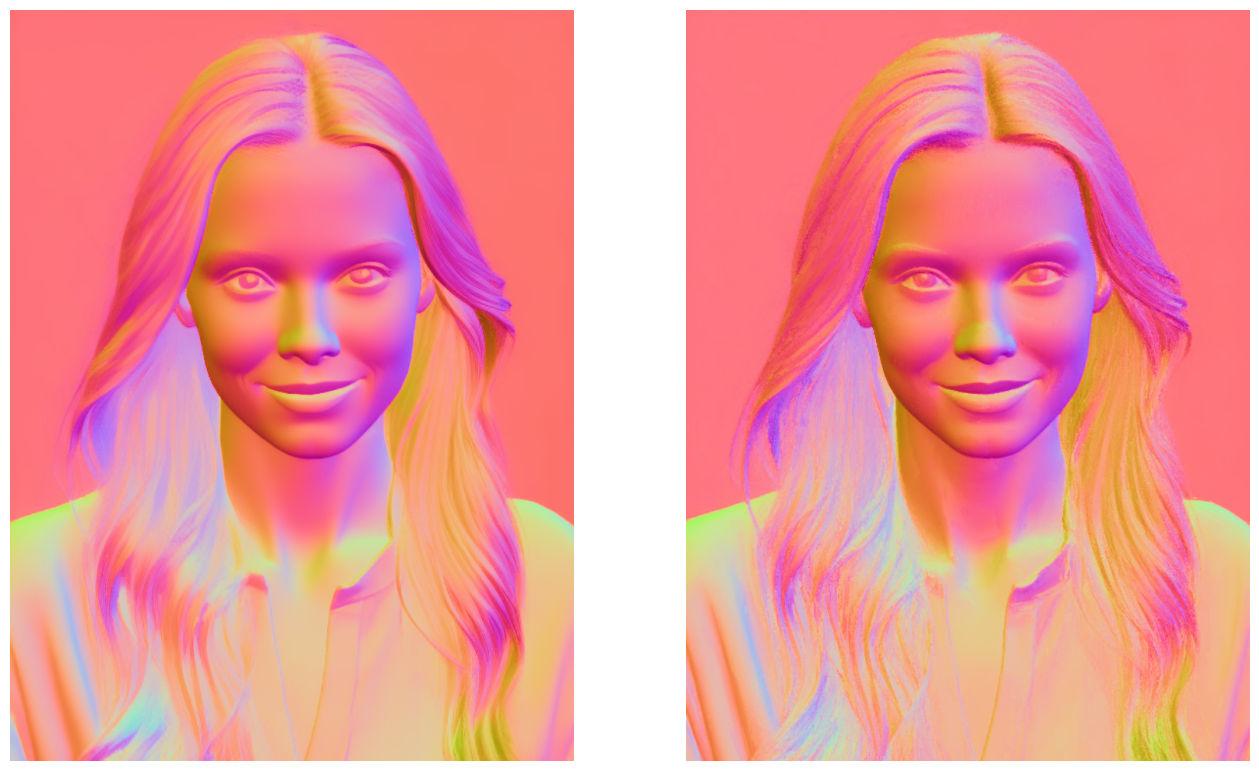

In [ ]:
image = diffusers.utils.load_image("mmpose/datasets/face-tests/girlface8.jpg")
run_normals_inference(image)

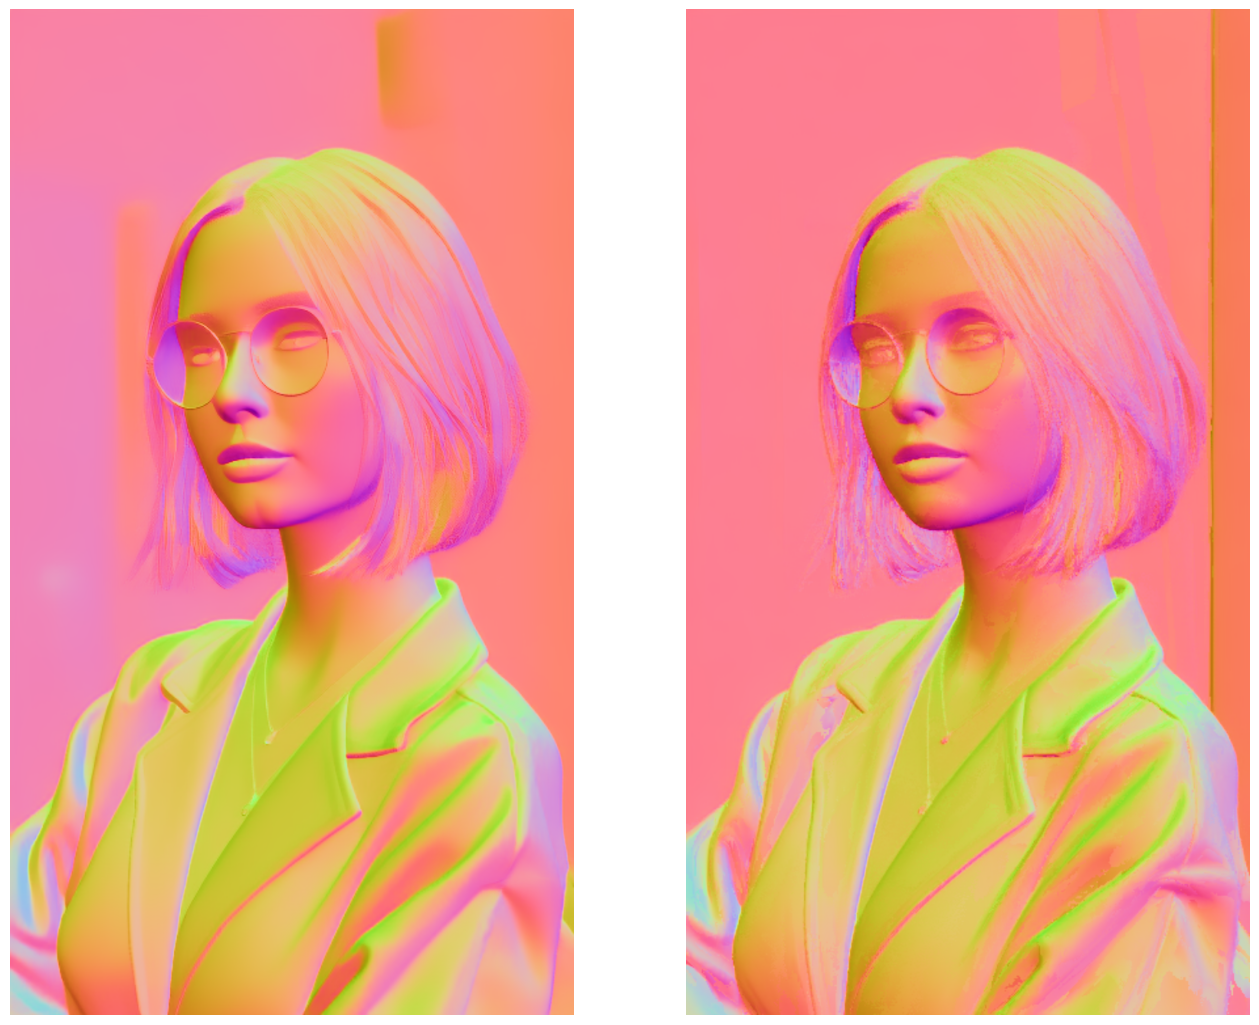

In [ ]:
image = diffusers.utils.load_image("mmpose/datasets/human-tests/human (1).jpg")
output_img, output_img2 = run_normals_inference(image)

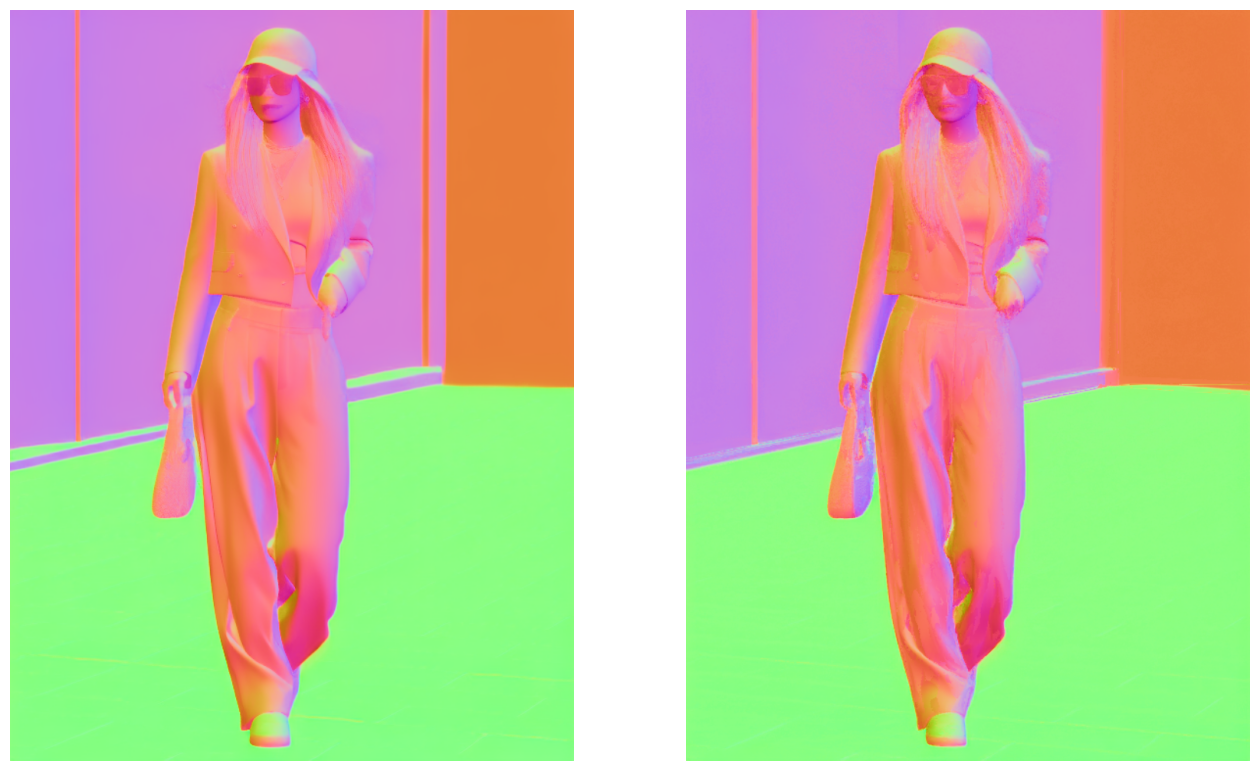

In [ ]:
image = diffusers.utils.load_image("mmpose/datasets/human-tests/human (10).jpg")
output_img, output_img2 = run_normals_inference(image)

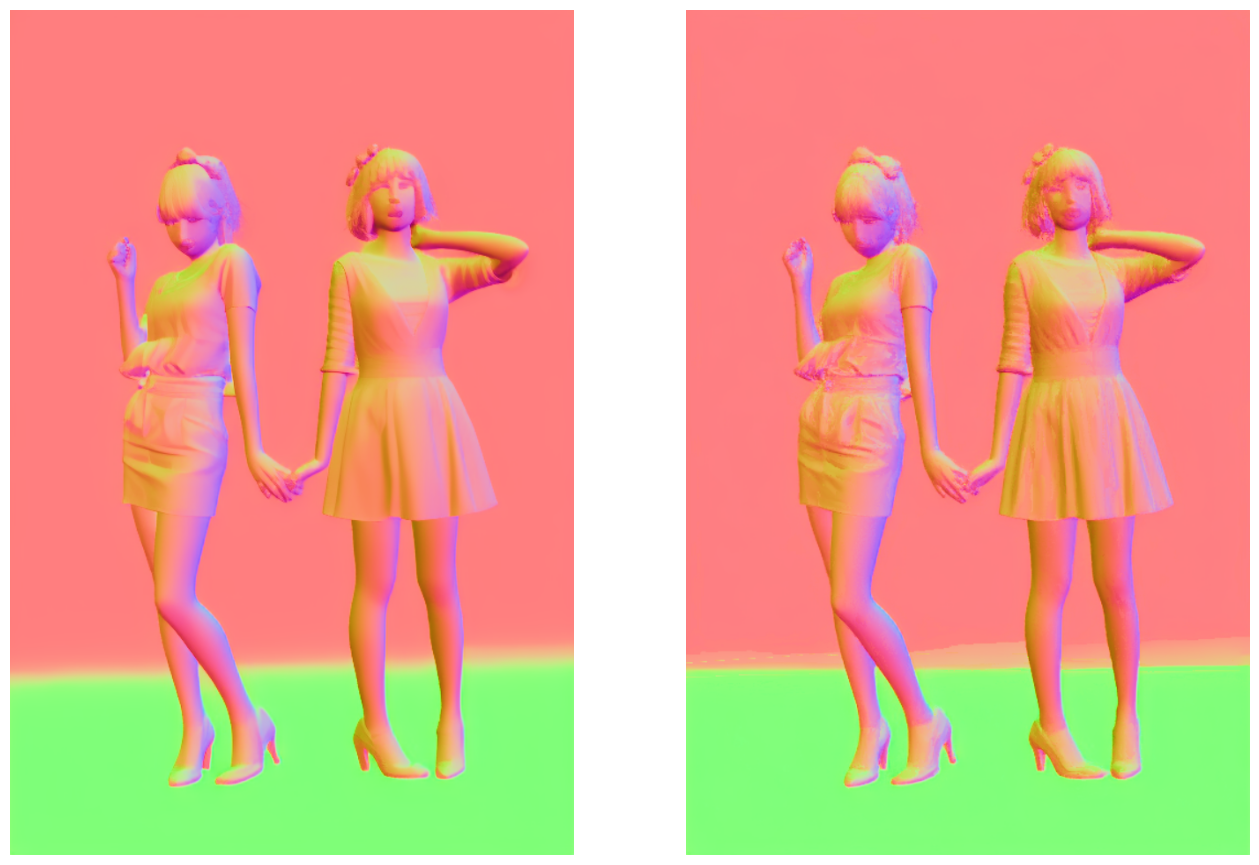

In [ ]:
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation

ins = instanceSegmentation()
ins.load_model("mit-models/pointrend_resnet50.pkl", confidence = 0.5)
target_classes = ins.select_target_classes(person = True)

results, output = ins.segmentImage("mmpose/datasets/human-tests/human (1).jpg", show_bboxes=False, segment_target_classes = target_classes, output_image_name=None)

img_path = "mmpose/datasets/human-tests/human (1).jpg"
orig = cv2.imread(img_path)
h, w = orig.shape[:2]

# Combine all object masks
# results["masks"] can be a list/array of shape (H, W, N) where N = number of objects
all_objects_mask = np.zeros((h, w), dtype=np.uint8)

# Check if PixelLib returned multiple masks
if "masks" in results:
    masks_array = results["masks"]
    if isinstance(masks_array, np.ndarray) and masks_array.ndim == 3:
        # (H, W, N) → merge all objects
        for i in range(masks_array.shape[2]):
            all_objects_mask = cv2.bitwise_or(all_objects_mask, (masks_array[:, :, i].astype(np.uint8) * 255))
    else:
        # fallback if single mask
        all_objects_mask = (masks_array.astype(np.uint8) * 255)
else:
    # fallback if only single mask available
    all_objects_mask = (results["mask"].astype(np.uint8) * 255)

# Invert mask for background
background_mask = cv2.bitwise_not(all_objects_mask)

# Create transparent RGBA image
bg_rgba = cv2.cvtColor(orig, cv2.COLOR_BGR2BGRA)
bg_rgba[:, :, 3] = background_mask

# Resize replacement background
output_img2 = cv2.resize(output_img2, (w, h))

# Optional: smooth alpha
alpha_raw = bg_rgba[:, :, 3].astype(float) / 255.0
kernel = np.ones((3, 3), np.uint8)
alpha_clean = cv2.morphologyEx(alpha_raw, cv2.MORPH_CLOSE, kernel)
alpha_smooth = cv2.GaussianBlur(alpha_clean, (25, 25), 0)
alpha = np.repeat(alpha_smooth[:, :, np.newaxis], 3, axis=2)

# Blend foreground and background
fg_rgb = bg_rgba[:, :, :3].astype(float)
bg_rgb = output_img2.astype(float)
combined = (fg_rgb * alpha + bg_rgb * (1 - alpha)).astype(np.uint8)

# Show result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

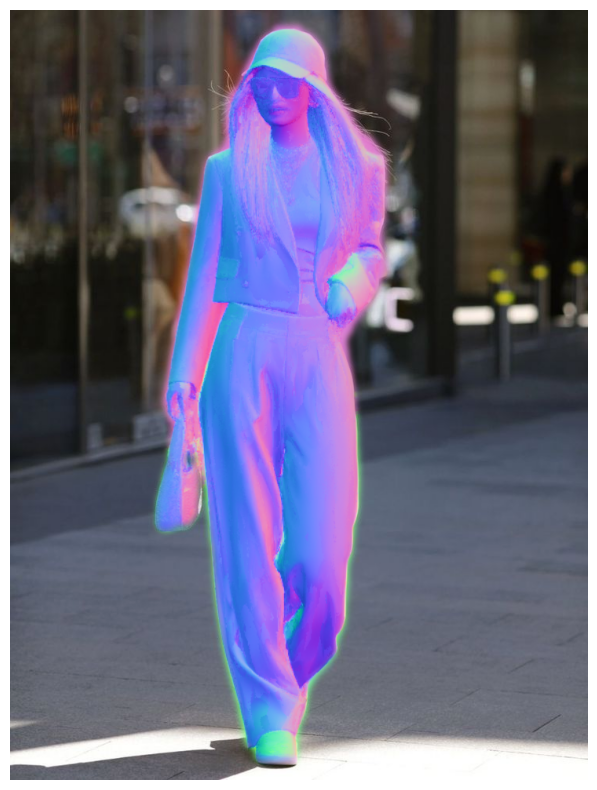

In [ ]:
def run_normals_inference_final(image, image_path):
    depth = pipe(image, num_inference_steps=10, ensemble_size=5)
    vis2 = pipe.image_processor.visualize_normals(depth.prediction)
    #vis[0].save("einstein_normals.png")
    # Convert PIL Image to NumPy array before color conversion
    output_img2 = cv2.cvtColor(np.array(vis2[0]), cv2.COLOR_BGR2RGB)

    results, output = ins.segmentImage(image_path, show_bboxes=False, segment_target_classes = target_classes, output_image_name=None)
    #print(results["masks"])
    orig = cv2.imread(image_path)
    h, w = orig.shape[:2]

    # Combine all object masks
    # results["masks"] can be a list/array of shape (H, W, N) where N = number of objects
    all_objects_mask = np.zeros((h, w), dtype=np.uint8)

    # Check if PixelLib returned multiple masks
    if "masks" in results:
        masks_array = results["masks"]
        if isinstance(masks_array, np.ndarray) and masks_array.ndim == 3:
            # (H, W, N) → merge all objects
            for i in range(masks_array.shape[2]):
                all_objects_mask = cv2.bitwise_or(all_objects_mask, (masks_array[:, :, i].astype(np.uint8) * 255))
        else:
            # fallback if single mask
            all_objects_mask = (masks_array.astype(np.uint8) * 255)
    else:
        # fallback if only single mask available
        all_objects_mask = (results["mask"].astype(np.uint8) * 255)

    # Invert mask for background
    background_mask = cv2.bitwise_not(all_objects_mask)

    # Create transparent RGBA image
    bg_rgba = cv2.cvtColor(orig, cv2.COLOR_BGR2BGRA)
    bg_rgba[:, :, 3] = background_mask

    # Resize replacement background
    output_img2 = cv2.resize(output_img2, (w, h))

    # Optional: smooth alpha
    alpha_raw = bg_rgba[:, :, 3].astype(float) / 255.0
    kernel = np.ones((3, 3), np.uint8)
    alpha_clean = cv2.morphologyEx(alpha_raw, cv2.MORPH_CLOSE, kernel)
    alpha_smooth = cv2.GaussianBlur(alpha_clean, (25, 25), 0)
    alpha = np.repeat(alpha_smooth[:, :, np.newaxis], 3, axis=2)

    # Blend foreground and background
    fg_rgb = bg_rgba[:, :, :3].astype(float)
    bg_rgb = output_img2.astype(float)
    combined = (fg_rgb * alpha + bg_rgb * (1 - alpha)).astype(np.uint8)

    # Show result
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

pipe = diffusers.MarigoldNormalsPipeline.from_pretrained(
    "prs-eth/marigold-normals-v1-1", variant="fp16", torch_dtype=torch.float16
).to("cuda")

import pixellib
from pixellib.torchbackend.instance import instanceSegmentation

ins = instanceSegmentation()
ins.load_model("mit-models/pointrend_resnet50.pkl", confidence = 0.2)
target_classes = ins.select_target_classes(person = True)

In [ ]:
image_path = "mmpose/datasets/human-tests/human (4).jpg"
image = diffusers.utils.load_image(image_path)
run_normals_inference_final(image, image_path)

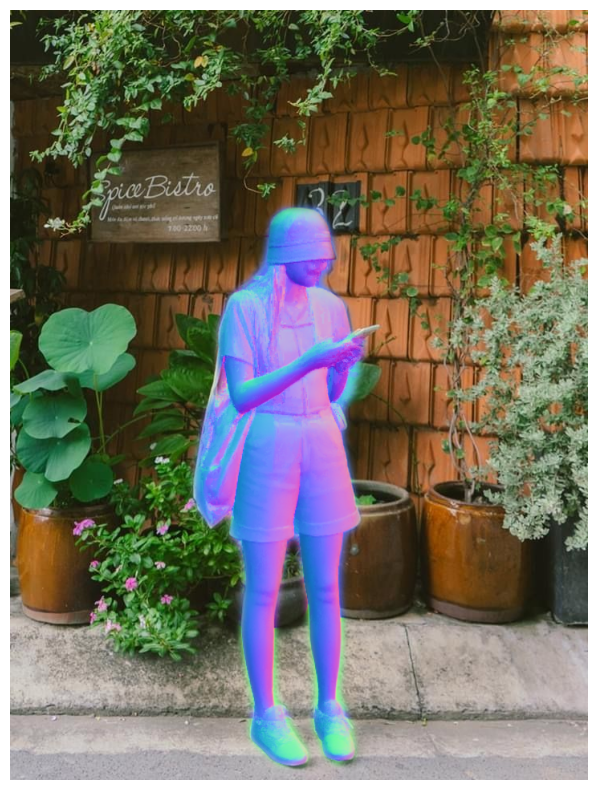

In [ ]:
image_path = "mmpose/datasets/human-tests/human (10).jpg"
image = diffusers.utils.load_image(image_path)
run_normals_inference_final(image, image_path)

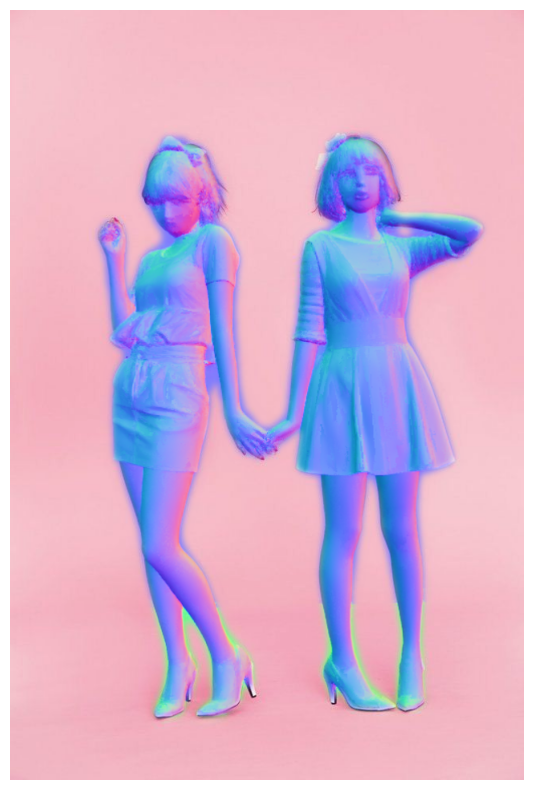

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation

image_path = "mmpose/datasets/human-tests/human (10).jpg"
image = diffusers.utils.load_image(image_path)
depth = pipe(image, num_inference_steps=10, ensemble_size=5)
vis2 = pipe.image_processor.visualize_normals(depth.prediction)

# Convert PIL to NumPy (RGB)
normal_relief = np.array(vis2[0])
# Convert to float and normalize
norm_float = normal_relief.astype(np.float32) / 255.0
norm_float = np.clip((norm_float - 0.5) * 2.0 + 0.5, 0, 1)  # simple contrast boost
enhanced_relief = (norm_float * 255).astype(np.uint8)
enhanced_relief = cv2.cvtColor(enhanced_relief, cv2.COLOR_BGR2RGB)

ins = instanceSegmentation()
ins.load_model("mit-models/pointrend_resnet50.pkl", confidence = 0.5)
target_classes = ins.select_target_classes(person = True)

results, output = ins.segmentImage("mmpose/datasets/human-tests/human (10).jpg", show_bboxes=False, segment_target_classes = target_classes, output_image_name=None)

img_path = "mmpose/datasets/human-tests/human (10).jpg"
orig = cv2.imread(img_path)
h, w = orig.shape[:2]

# Combine all object masks
# results["masks"] can be a list/array of shape (H, W, N) where N = number of objects
all_objects_mask = np.zeros((h, w), dtype=np.uint8)

# Check if PixelLib returned multiple masks
if "masks" in results:
    masks_array = results["masks"]
    if isinstance(masks_array, np.ndarray) and masks_array.ndim == 3:
        # (H, W, N) → merge all objects
        for i in range(masks_array.shape[2]):
            all_objects_mask = cv2.bitwise_or(all_objects_mask, (masks_array[:, :, i].astype(np.uint8) * 255))
    else:
        # fallback if single mask
        all_objects_mask = (masks_array.astype(np.uint8) * 255)
else:
    # fallback if only single mask available
    all_objects_mask = (results["mask"].astype(np.uint8) * 255)

# Invert mask for background
background_mask = cv2.bitwise_not(all_objects_mask)

# Create transparent RGBA image
bg_rgba = cv2.cvtColor(orig, cv2.COLOR_BGR2BGRA)
bg_rgba[:, :, 3] = background_mask

# Resize replacement background
enhanced_relief = cv2.resize(enhanced_relief, (w, h))

# Optional: smooth alpha
alpha_raw = bg_rgba[:, :, 3].astype(float) / 255.0
kernel = np.ones((3, 3), np.uint8)
alpha_clean = cv2.morphologyEx(alpha_raw, cv2.MORPH_CLOSE, kernel)
alpha_smooth = cv2.GaussianBlur(alpha_clean, (25, 25), 0)
alpha = np.repeat(alpha_smooth[:, :, np.newaxis], 3, axis=2)

# Blend foreground and background
fg_rgb = bg_rgba[:, :, :3].astype(float)
bg_rgb = enhanced_relief.astype(float)
combined = (fg_rgb * alpha + bg_rgb * (1 - alpha)).astype(np.uint8)

# Show result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

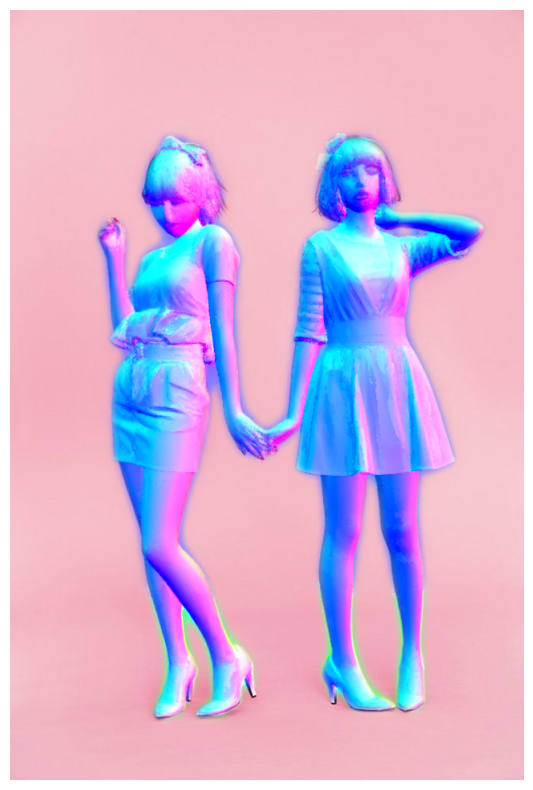

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import binary_erosion
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

H, W, _ = combined.shape

# Mask for objects only (invert if needed)
mask = alpha_smooth > 0.05
mask = ~mask

# Convert BGR → RGB to preserve original normals
facecolors = combined[..., ::-1].astype(np.float32) / 255.0

# 3D grid
X, Y = np.meshgrid(np.arange(W), np.arange(H))
Y = H - Y   # flip Y so upright

X = X.astype(np.float32)
Y = Y.astype(np.float32)

# Depth (this only controls extrusion distance)
depth = 0.1   # try 0.5, 1, 2, etc.

# Front face (always at Z=0, original normals)
Xf, Yf, Zf = X.copy(), Y.copy(), np.zeros_like(X, dtype=np.float32)
Xf[~mask], Yf[~mask], Zf[~mask] = np.nan, np.nan, np.nan

# Back face (always at Z=-depth, darker copy)
Xb, Yb, Zb = X.copy(), Y.copy(), -depth * np.ones_like(X, dtype=np.float32)
Xb[~mask], Yb[~mask], Zb[~mask] = np.nan, np.nan, np.nan

# Masked colors (original normals only on object)
facecolors_masked = np.zeros_like(facecolors)
facecolors_masked[mask] = facecolors[mask]

# Plot
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

#stone_rgb = (0.72, 0.70, 0.66)  # warm stone
stone_rgb = (164/255, 116/255, 73/255)
stone_face = np.tile(stone_rgb, (H, W, 1))  # broadcast to (H,W,3)
# Front face
ax.plot_surface(Xf, Zf, Yf, facecolors=stone_face,
                rstride=1, cstride=1, linewidth=0, antialiased=False, shade=False)

# Back face
ax.plot_surface(Xb, Zb, Yb, facecolors=facecolors_masked,
                rstride=1, cstride=1, linewidth=0, antialiased=False, shade=False)

# Side walls
edges = mask & ~binary_erosion(mask)
edge_y, edge_x = np.where(edges)
for ex, ey in zip(edge_x, edge_y):
    X_wall = [ex, ex, ex, ex]
    Y_wall = [H-ey, H-ey, H-ey, H-ey]
    Z_wall = [0, -depth, -depth, 0]
    verts = [list(zip(X_wall, Z_wall, Y_wall))]
    poly = Poly3DCollection(verts, facecolor=stone_rgb, edgecolor=stone_rgb, alpha=1.0)
    ax.add_collection3d(poly)

# Axes
ax.set_xlabel("X (width)")
ax.set_ylabel("Z (depth)")
ax.set_zlabel("Y (height)")
ax.set_xlim(0, W)
ax.set_ylim(-depth*1.5, 1)
ax.set_zlim(0, H)
ax.view_init(elev=20, azim=-60)
ax.grid(True)

plt.show()

In [ ]:
import random
import os
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation

pipe = diffusers.MarigoldNormalsPipeline.from_pretrained(
    "prs-eth/marigold-normals-v1-1", variant="fp16", torch_dtype=torch.float16
).to("cuda")

ins = instanceSegmentation()
ins.load_model("mit-models/pointrend_resnet50.pkl", confidence = 0.5)
target_classes = ins.select_target_classes(person = True)

# --- Config ---
val_dir = "mmpose/datasets/human-tests"

num_samples = 8

# --- Load Images ---
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

img_list = []

for img_name in selected_imgs:
    img_path = os.path.join(val_dir, img_name)
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_list.append((img_name, img_path, img_rgb))

# --- Plotting ---
cols = 4
rows = (len(img_list) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for idx, (img_name, img_path, img_rgb) in enumerate(img_list):
    image = diffusers.utils.load_image(img_path)

    depth = pipe(image, num_inference_steps=10, ensemble_size=5)
    vis2 = pipe.image_processor.visualize_normals(depth.prediction)
    #vis[0].save("einstein_normals.png")
    # Convert PIL Image to NumPy array before color conversion
    output_img2 = cv2.cvtColor(np.array(vis2[0]), cv2.COLOR_BGR2RGB)

    results, output = ins.segmentImage(img_path, show_bboxes=False, segment_target_classes = target_classes, output_image_name=None)

    orig = cv2.imread(img_path)
    h, w = orig.shape[:2]

    # Combine all object masks
    # results["masks"] can be a list/array of shape (H, W, N) where N = number of objects
    all_objects_mask = np.zeros((h, w), dtype=np.uint8)

    # Check if PixelLib returned multiple masks
    if "masks" in results:
        masks_array = results["masks"]
        if isinstance(masks_array, np.ndarray) and masks_array.ndim == 3:
            # (H, W, N) → merge all objects
            for i in range(masks_array.shape[2]):
                all_objects_mask = cv2.bitwise_or(all_objects_mask, (masks_array[:, :, i].astype(np.uint8) * 255))
        else:
            # fallback if single mask
            all_objects_mask = (masks_array.astype(np.uint8) * 255)
    else:
        # fallback if only single mask available
        all_objects_mask = (results["mask"].astype(np.uint8) * 255)

    # Invert mask for background
    background_mask = cv2.bitwise_not(all_objects_mask)

    # Create transparent RGBA image
    bg_rgba = cv2.cvtColor(orig, cv2.COLOR_BGR2BGRA)
    bg_rgba[:, :, 3] = background_mask

    # Resize replacement background
    output_img2 = cv2.resize(output_img2, (w, h))

    # Optional: smooth alpha
    alpha_raw = bg_rgba[:, :, 3].astype(float) / 255.0
    kernel = np.ones((3, 3), np.uint8)
    alpha_clean = cv2.morphologyEx(alpha_raw, cv2.MORPH_CLOSE, kernel)
    alpha_smooth = cv2.GaussianBlur(alpha_clean, (25, 25), 0)
    alpha = np.repeat(alpha_smooth[:, :, np.newaxis], 3, axis=2)

    # Blend foreground and background
    fg_rgb = bg_rgba[:, :, :3].astype(float)
    bg_rgb = output_img2.astype(float)
    combined = (fg_rgb * alpha + bg_rgb * (1 - alpha)).astype(np.uint8)

    img_vis = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_vis)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import random
import os
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation

pipe = diffusers.MarigoldNormalsPipeline.from_pretrained(
    "prs-eth/marigold-normals-v1-1", variant="fp16", torch_dtype=torch.float16
).to("cuda")

ins = instanceSegmentation()
ins.load_model("mit-models/pointrend_resnet50.pkl", confidence = 0.5)
target_classes = ins.select_target_classes(person = True)

# --- Config ---
val_dir = "mmpose/datasets/face-tests"

num_samples = 8

# --- Load Images ---
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

img_list = []

for img_name in selected_imgs:
    img_path = os.path.join(val_dir, img_name)
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_list.append((img_name, img_path, img_rgb))

# --- Plotting ---
cols = 4
rows = (len(img_list) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for idx, (img_name, img_path, img_rgb) in enumerate(img_list):
    image = diffusers.utils.load_image(img_path)

    depth = pipe(image, num_inference_steps=10, ensemble_size=5)
    vis2 = pipe.image_processor.visualize_normals(depth.prediction)
    #vis[0].save("einstein_normals.png")
    # Convert PIL Image to NumPy array before color conversion
    output_img2 = cv2.cvtColor(np.array(vis2[0]), cv2.COLOR_BGR2RGB)

    results, output = ins.segmentImage(img_path, show_bboxes=False, segment_target_classes = target_classes, output_image_name=None)

    orig = cv2.imread(img_path)
    h, w = orig.shape[:2]

    # Combine all object masks
    # results["masks"] can be a list/array of shape (H, W, N) where N = number of objects
    all_objects_mask = np.zeros((h, w), dtype=np.uint8)

    # Check if PixelLib returned multiple masks
    if "masks" in results:
        masks_array = results["masks"]
        if isinstance(masks_array, np.ndarray) and masks_array.ndim == 3:
            # (H, W, N) → merge all objects
            for i in range(masks_array.shape[2]):
                all_objects_mask = cv2.bitwise_or(all_objects_mask, (masks_array[:, :, i].astype(np.uint8) * 255))
        else:
            # fallback if single mask
            all_objects_mask = (masks_array.astype(np.uint8) * 255)
    else:
        # fallback if only single mask available
        all_objects_mask = (results["mask"].astype(np.uint8) * 255)

    # Invert mask for background
    background_mask = cv2.bitwise_not(all_objects_mask)

    # Create transparent RGBA image
    bg_rgba = cv2.cvtColor(orig, cv2.COLOR_BGR2BGRA)
    bg_rgba[:, :, 3] = background_mask

    # Resize replacement background
    output_img2 = cv2.resize(output_img2, (w, h))

    # Optional: smooth alpha
    alpha_raw = bg_rgba[:, :, 3].astype(float) / 255.0
    kernel = np.ones((3, 3), np.uint8)
    alpha_clean = cv2.morphologyEx(alpha_raw, cv2.MORPH_CLOSE, kernel)
    alpha_smooth = cv2.GaussianBlur(alpha_clean, (25, 25), 0)
    alpha = np.repeat(alpha_smooth[:, :, np.newaxis], 3, axis=2)

    # Blend foreground and background
    fg_rgb = bg_rgba[:, :, :3].astype(float)
    bg_rgb = output_img2.astype(float)
    combined = (fg_rgb * alpha + bg_rgb * (1 - alpha)).astype(np.uint8)

    img_vis = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_vis)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import random
import os
import pixellib
from pixellib.torchbackend.instance import instanceSegmentation

pipe = diffusers.MarigoldNormalsPipeline.from_pretrained(
    "prs-eth/marigold-normals-v1-1", variant="fp16", torch_dtype=torch.float16
).to("cuda")

ins = instanceSegmentation()
ins.load_model("mit-models/pointrend_resnet50.pkl", confidence = 0.5)

# --- Config ---
val_dir = "mmpose/datasets/vitpose_models"

num_samples = 8

# --- Load Images ---
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

img_list = []

for img_name in selected_imgs:
    img_path = os.path.join(val_dir, img_name)
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_list.append((img_name, img_path, img_rgb))

# --- Plotting ---
cols = 4
rows = (len(img_list) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for idx, (img_name, img_path, img_rgb) in enumerate(img_list):
    image = diffusers.utils.load_image(img_path)

    depth = pipe(image, num_inference_steps=10, ensemble_size=5)
    vis2 = pipe.image_processor.visualize_normals(depth.prediction)
    #vis[0].save("einstein_normals.png")
    # Convert PIL Image to NumPy array before color conversion
    output_img2 = cv2.cvtColor(np.array(vis2[0]), cv2.COLOR_BGR2RGB)

    results, output = ins.segmentImage(img_path, show_bboxes=False, output_image_name=None)

    orig = cv2.imread(img_path)
    h, w = orig.shape[:2]

    # Combine all object masks
    # results["masks"] can be a list/array of shape (H, W, N) where N = number of objects
    all_objects_mask = np.zeros((h, w), dtype=np.uint8)

    # Check if PixelLib returned multiple masks
    if "masks" in results:
        masks_array = results["masks"]
        if isinstance(masks_array, np.ndarray) and masks_array.ndim == 3:
            # (H, W, N) → merge all objects
            for i in range(masks_array.shape[2]):
                all_objects_mask = cv2.bitwise_or(all_objects_mask, (masks_array[:, :, i].astype(np.uint8) * 255))
        else:
            # fallback if single mask
            all_objects_mask = (masks_array.astype(np.uint8) * 255)
    else:
        # fallback if only single mask available
        all_objects_mask = (results["mask"].astype(np.uint8) * 255)

    # Invert mask for background
    background_mask = cv2.bitwise_not(all_objects_mask)

    # Create transparent RGBA image
    bg_rgba = cv2.cvtColor(orig, cv2.COLOR_BGR2BGRA)
    bg_rgba[:, :, 3] = background_mask

    # Resize replacement background
    output_img2 = cv2.resize(output_img2, (w, h))

    # Optional: smooth alpha
    alpha_raw = bg_rgba[:, :, 3].astype(float) / 255.0
    kernel = np.ones((3, 3), np.uint8)
    alpha_clean = cv2.morphologyEx(alpha_raw, cv2.MORPH_CLOSE, kernel)
    alpha_smooth = cv2.GaussianBlur(alpha_clean, (25, 25), 0)
    alpha = np.repeat(alpha_smooth[:, :, np.newaxis], 3, axis=2)

    # Blend foreground and background
    fg_rgb = bg_rgba[:, :, :3].astype(float)
    bg_rgb = output_img2.astype(float)
    combined = (fg_rgb * alpha + bg_rgb * (1 - alpha)).astype(np.uint8)

    img_vis = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_vis)
    plt.axis('off')

plt.tight_layout()
plt.show()